In [3]:
DATA_PATH = '../data/datasets/housing/housing.csv'
EXPORT_PATH = "../data/processed/01_preprocessed_df.pkl"


In [4]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  


In [5]:
# read data
df = pd.read_csv(DATA_PATH)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


--------

### EDA

<Axes: xlabel='longitude', ylabel='latitude'>

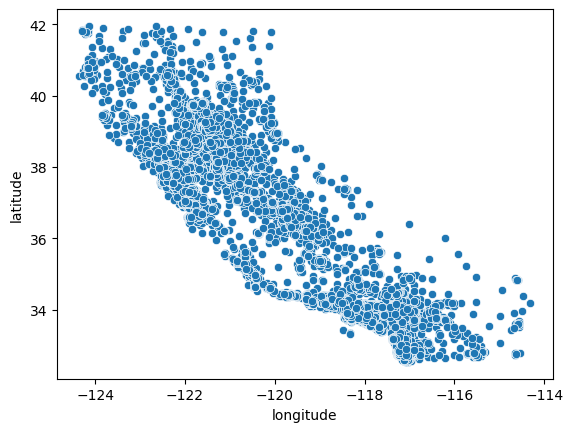

In [11]:
sns.scatterplot(x='longitude', y='latitude', data=df)

<Axes: xlabel='longitude', ylabel='latitude'>

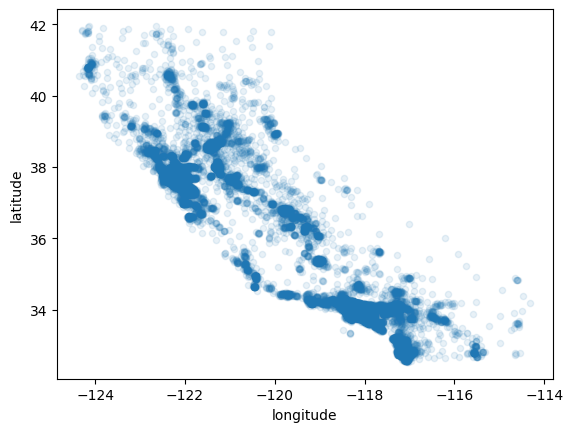

In [13]:
# let's make alpha=0.1 to see the high density of data
df.plot(kind='scatter', x='longitude', y='latitude',alpha=0.1)

Now that’s much better: you can clearly see the high-density areas, namely the Bay
Area and around Los Angeles and San Diego, plus a long line of fairly high density in
the Central Valley, in particular around Sacramento and Fresno

<Axes: xlabel='longitude', ylabel='latitude'>

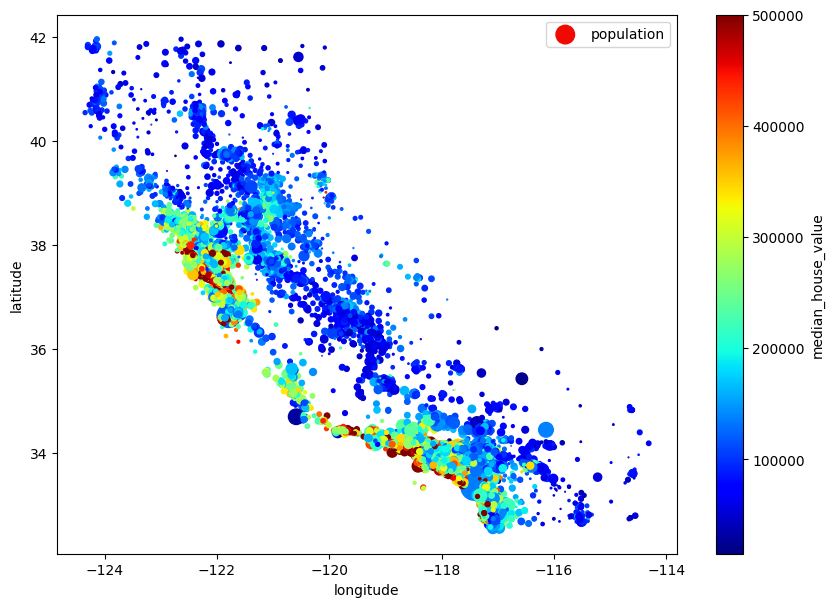

In [16]:
df.plot(kind="scatter", x="longitude", y="latitude", grid=False,
             s=df["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))


>this image tells you that the housing prices are very much related to the location
(e.g., close to the ocean) and to the population density, as you probably knew already.
It will probably be useful to use a clustering algorithm to detect the main clusters, and
add new features that measure the proximity to the cluster centers. The ocean prox‐
imity attribute may be useful as well, although in Northern California the housing
prices in coastal districts are not too high

---------

#### Looking for Correlations

In [6]:
num_df = df._get_numeric_data()
corr_matrix = num_df.corr()

In [7]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

<Axes: >

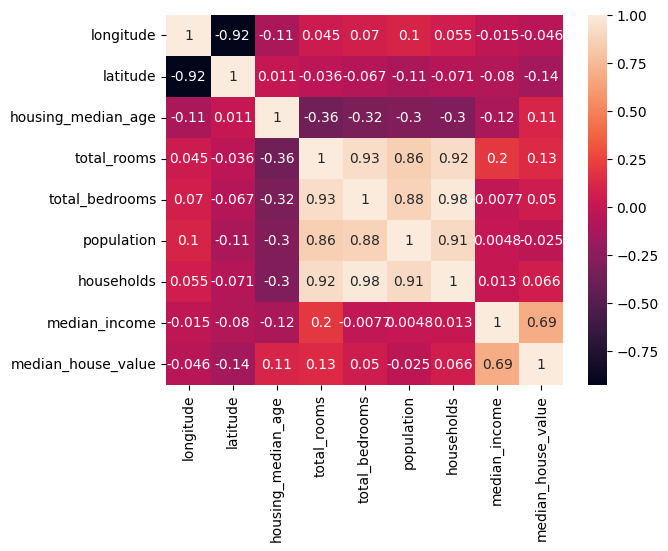

In [22]:
# see heat map
sns.heatmap(corr_matrix, annot=True)

>The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that
there is a strong positive correlation; for example, the median house value tends to go
up when the median income goes up. When the coefficient is close to –1, it means
that there is a strong negative correlation; you can see a small negative correlation
between the latitude and the median house value (i.e., prices have a slight tendency to
go down when you go north). Finally, coefficients close to zero mean that there is no
linear correlation

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

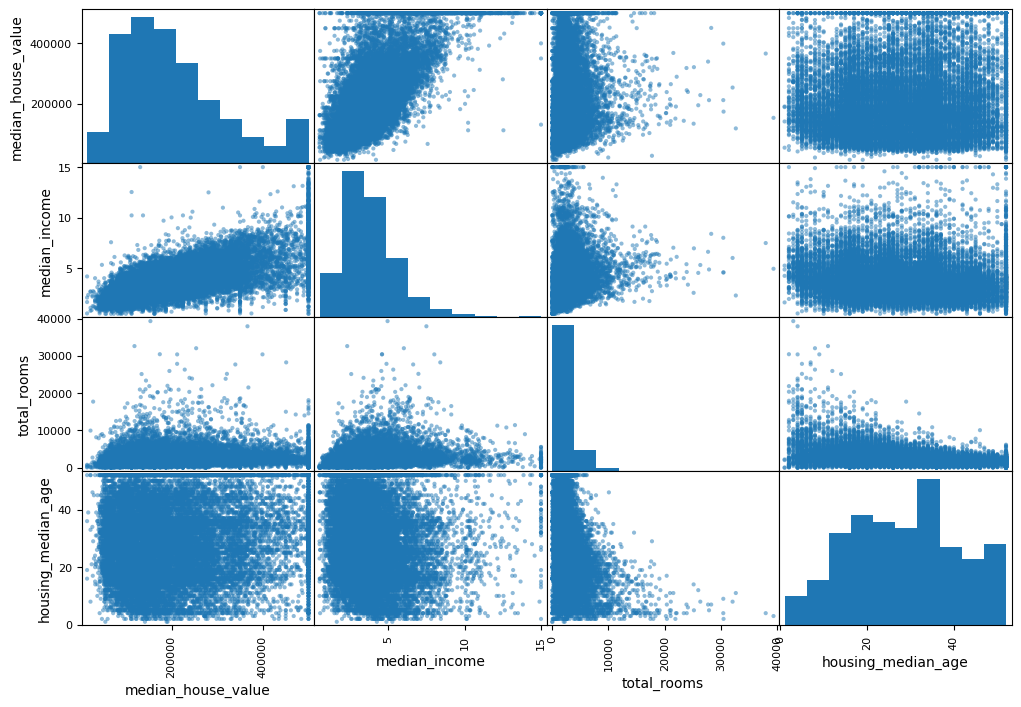

In [8]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms","housing_median_age"]
scatter_matrix(df[attributes], figsize=(12, 8))


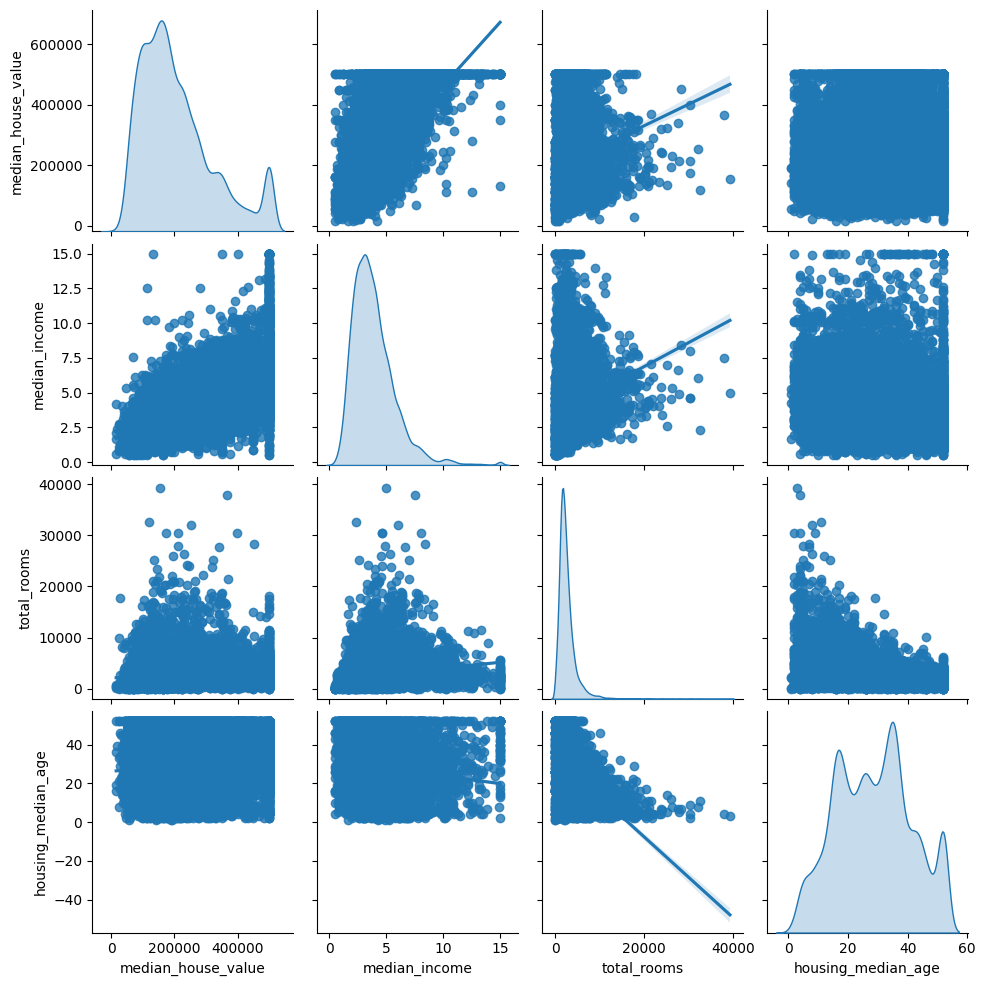

In [29]:
sns.pairplot(df[attributes], diag_kind="kde",kind="reg",)

The most promising attribute to predict the median house value is the median
income, so let’s zoom in on their correlation scatterplot

<Axes: xlabel='median_income', ylabel='median_house_value'>

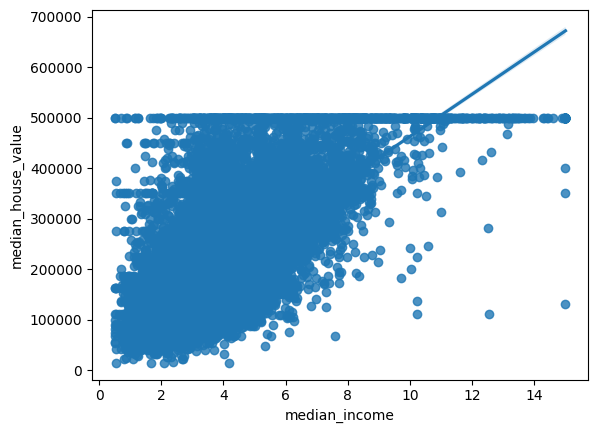

In [9]:
sns.regplot(x="median_income", y="median_house_value", data=df)

----------

### Feature Engineering

>the total number of rooms in a district is not very useful if you don’t know how many
households there are. What you really want is the number of rooms per household.
Similarly, the total number of bedrooms by itself is not very useful: you probably
want to compare it to the number of rooms. And the population per household also

In [10]:
df1 = df.copy()

In [11]:
df1["rooms_per_house"] = df1["total_rooms"] / df1["households"]
df1["bedrooms_ratio"] = df1["total_bedrooms"] / df1["total_rooms"]
df1["people_per_house"] = df1["population"] / df1["households"]

In [12]:
num_df1 = df1._get_numeric_data()
corr_matrix = num_df1.corr()

In [13]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
rooms_per_house       0.151948
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
people_per_house     -0.023737
population           -0.024650
longitude            -0.045967
latitude             -0.144160
bedrooms_ratio       -0.255880
Name: median_house_value, dtype: float64

<Axes: >

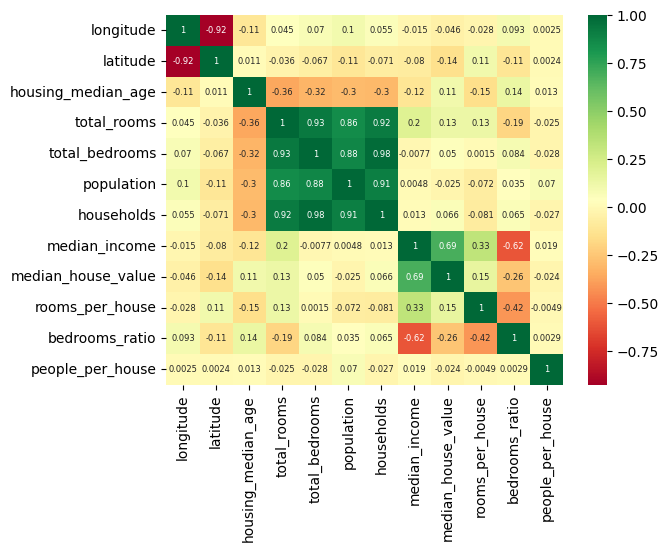

In [48]:
sns.heatmap(corr_matrix, annot=True, cmap="RdYlGn",annot_kws={"size":6})

>The new bedrooms_per_room attribute is much more correlated with
the median house value than the total number of rooms or bedrooms. Apparently
houses with a lower bedroom/room ratio tend to be more expensive. The number of
rooms per household is also more informative than the total number of rooms in a
district—obviously the larger the houses, the more expensive they are

----------

### EXPORT

In [52]:
pd.to_pickle(df1, EXPORT_PATH)